# 13.7. 单发多框检测（SSD）

在 13.3节— 13.6节中，我们分别介绍了边界框、锚框、多尺度目标检测和用于目标检测的数据集。 现在我们已经准备好使用这样的背景知识来设计一个目标检测模型：单发多框检测（SSD） ([Liu et al., 2016](https://zh-v2.d2l.ai/chapter_references/zreferences.html#id98))。 该模型简单、快速且被广泛使用。尽管这只是其中一种目标检测模型，但本节中的一些设计原则和实现细节也适用于其他模型。

## 13.7.1. 模型
图13.7.1描述了单发多框检测模型的设计。 此模型主要由基础网络组成，其后是几个多尺度特征块。 基本网络用于从输入图像中提取特征，因此它可以使用深度卷积神经网络。 单发多框检测论文中选用了在分类层之前截断的VGG (Liu et al., 2016)，现在也常用ResNet替代。 我们可以设计基础网络，使它输出的高和宽较大。 这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。 接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。

回想一下在 13.5节中，通过深度神经网络分层表示图像的多尺度目标检测的设计。 由于接近 图13.7.1顶部的多尺度特征图较小，但具有较大的感受野，它们适合检测较少但较大的物体。 简而言之，通过多尺度特征块，单发多框检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来检测大小不同的目标，因此这是一个多尺度目标检测模型。

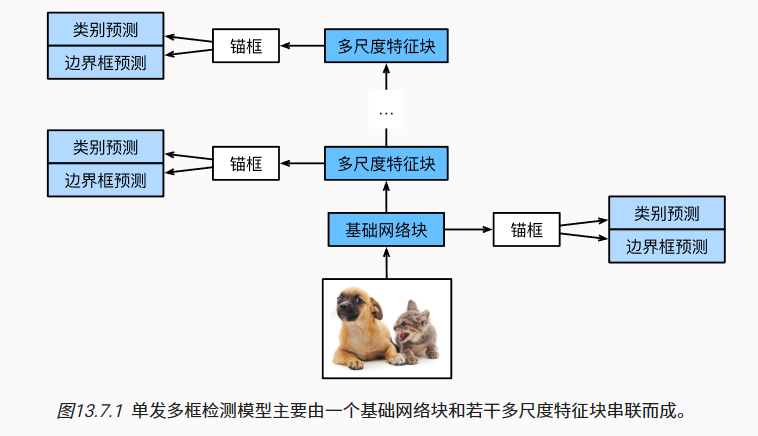

在下面，我们将介绍 图13.7.1中不同块的实施细节。 首先，我们将讨论如何实施类别和边界框预测。

### 13.7.1.1. 类别预测层
设目标类别的数量为$q$。这样一来，锚框有$q+1$个类别，其中0类是背景。 在某个尺度下，设特征图的高和宽分别为$h$和$w$。 如果以其中每个单元为中心生成$a$个锚框，那么我们需要对$hwa$个锚框进行分类。 如果使用全连接层作为输出，很容易导致模型参数过多。 回忆 7.3节一节介绍的使用卷积层的通道来输出类别预测的方法， 单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。 这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。 考虑输出和输入同一空间坐标$(x,y)$：输出特征图上$(x,y)$坐标的通道里包含了以输入特征图$(x,y)$坐标为中心生成的所有锚框的类别预测。 因此输出通道数为$a(q+1)$，其中索引为$i(q+1)+j \quad (0 \leq j \leq q)$的通道代表了索引为$i$的锚框有关类别索引为$j$的预测。

在下面，我们定义了这样一个类别预测层，通过参数num_anchors和num_classes分别指定了$a$和$q$。 该图层使用填充为1的$3 \times 3$的卷积层。此卷积层的输入和输出的宽度和高度保持不变。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### 13.7.1.2. 边界框预测层
边界框预测层的设计与类别预测层的设计类似。 唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是$q+1$个类别。

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### 13.7.1.3. 连结多尺度的预测
正如我们所提到的，单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量。 在不同的尺度下，特征图的形状或以同一单元为中心的锚框的数量可能会有所不同。 因此，不同尺度下预测输出的形状可能会有所不同。

在以下示例中，我们为同一个小批量构建两个不同比例（Y1和Y2）的特征图，其中Y2的高度和宽度是Y1的一半。 以类别预测为例，假设Y1和Y2的每个单元分别生成了$5$个和$3$个锚框。 进一步假设目标类别的数量为$10$，对于特征图Y1和Y2，类别预测输出中的通道数分别为$5 \times (10 + 1) = 55$和$3 \times (10 + 1)=33$，其中任一输出的形状是（批量大小，通道数，高度，宽度）。

In [3]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。 因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，$高 \times 宽 \times 通道数$）的格式，以方便之后在维度$1$上的连结。

In [4]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

这样一来，尽管Y1和Y2在通道数、高度和宽度方面具有不同的大小，我们仍然可以在同一个小批量的两个不同尺度上连接这两个预测输出。

In [5]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### 13.7.1.4. 高和宽减半块
为了在多个尺度下检测目标，我们在下面定义了高和宽减半块down_sample_blk，该模块将输入特征图的高度和宽度减半。 事实上，该块应用了在 subsec_vgg-blocks中的VGG模块设计。 更具体地说，每个高和宽减半块由两个填充为$1$的$3 \times 3$的卷积层、以及步幅为$2$的$2 \times 2$最大汇聚层组成。 我们知道，填充为$1$的$3 \times 3$卷积层不改变特征图的形状。但是，其后的$2 \times 2$的最大汇聚层将输入特征图的高度和宽度减少了一半。 对于此高和宽减半块的输入和输出特征图，因为$1 \times 2 + (3-1)+(3-1)=6$，所以输出中的每个单元在输入上都有一个$6 \times 6$的感受野。因此，高和宽减半块会扩大每个单元在其输出特征图中的感受野。

In [6]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

在以下示例中，我们构建的高和宽减半块会更改输入通道的数量，并将输入特征图的高度和宽度减半。

In [7]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### 13.7.1.5. 基本网络块
基本网络块用于从输入图像中抽取特征。 为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。 给定输入图像的形状为$256 \times 256$，此基本网络块输出的特征图形状为$32 \times 32 \quad (256/2^3)=32$。

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 13.7.1.6. 完整的模型
完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是 图13.7.1中的多尺度特征块。

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

现在我们为每个块定义前向传播。与图像分类任务不同，此处的输出包括：CNN特征图Y；在当前尺度下根据Y生成的锚框；预测的这些锚框的类别和偏移量（基于Y）。

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

回想一下，在 图13.7.1中，一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框。 在上面的前向传播中，在每个多尺度特征块上，我们通过调用的multibox_prior函数（见 13.4节）的sizes参数传递两个比例值的列表。 在下面，0.2和1.05之间的区间被均匀分成五个部分，以确定五个模块的在不同尺度下的较小值：0.2、0.37、0.54、0.71和0.88。 之后，他们较大的值由$\sqrt{0.2 \times 0.37}=0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等给出。

In [12]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们就可以按如下方式定义完整的模型TinySSD了。

In [13]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

我们创建一个模型实例，然后使用它对一个$256 \times 256$像素的小批量图像X执行前向传播。

如本节前面部分所示，第一个模块输出特征图的形状为$32 \times 32$。 回想一下，第二到第四个模块为高和宽减半块，第五个模块为全局汇聚层。 由于以特征图的每个单元为中心有$4$个锚框生成，因此在所有五个尺度下，每个图像总共生成$(32^2+16^2+8^2+4^2+1)\times 4 = 5444$个锚框。

In [14]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


d:\anaconda3\envs\pytorch131\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 13.7.2. 训练模型
现在，我们将描述如何训练用于目标检测的单发多框检测模型。

### 13.7.2.1. 读取数据集和初始化
首先，让我们读取 13.6节中描述的香蕉检测数据集。

In [15]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


香蕉检测数据集中，目标的类别数为1。 定义好模型后，我们需要初始化其参数并定义优化算法。

In [16]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [17]:
device

device(type='cuda', index=0)

### 13.7.2.2. 定义损失函数和评价函数
目标检测有两种类型的损失。 第一种有关锚框类别的损失：我们可以简单地复用之前图像分类问题里一直使用的交叉熵损失函数来计算； 第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。 但是，对于这个回归问题，我们在这里不使用 3.1.3节中描述的平方损失，而是使用$L_1$范数损失，即预测值和真实值之差的绝对值。 掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。 最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。

In [18]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

我们可以沿用准确率评价分类结果。 由于偏移量使用了$L_1$范数损失，我们使用平均绝对误差来评价边界框的预测结果。这些预测结果是从生成的锚框及其预测偏移量中获得的。

In [19]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### 13.7.2.3. 训练模型
在训练模型时，我们需要在模型的前向传播过程中生成多尺度锚框（anchors），并预测其类别（cls_preds）和偏移量（bbox_preds）。 然后，我们根据标签信息Y为生成的锚框标记类别（cls_labels）和偏移量（bbox_labels）。 最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

class err 3.26e-03, bbox mae 3.22e-03
7772.6 examples/sec on cuda:0


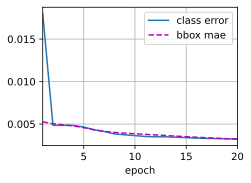

In [20]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')